# Project Tasks

In the first few assignments, we have learned how to infer part based components (known as mutational signatures) generated by particular mutational processes using Non-negative Matrix Factorization (NMF). By doing this, we are trying to reconstruct the mutation catalog in a given sample with mutational signatures and their contributions.

In this group project, you will use similar mutational profiles and signature activities to predict cancer types but with much larger sample size. 
You should:
* Separate the data into training and test groups within each cancer type.
* Find out which features are informative for the prediction of the cancer type (label). You should combine the profiles and activities and use each data type independently.
* Implement different models for classification of the samples given the input data and evaluate the model performance using test data to avoid overfitting. Explain briefly how does each model that you have used work.
* Report model performance, using standard machine learning metrics such as confusion matrices etc. 
* Compare model performance across methods and across cancer types, are some types easier top predict than others.
* Submit a single Jupyter notebook as the final report and present that during the last assignment session 

# Data

The data include both mutational catalogs from multiple cancers and the predicted activities in the paper ["Alexandrov LB, et al. (2020) The repertoire of mutational signatures in human cancer"](https://www.nature.com/articles/s41586-020-1943-3). The data either are generated from whole human genome (WGS) or only exomes regions (WES). Since the exome region only constitutes about 1% of human genome, the total mutation numbers in these samples are, of course, much smaller. So if you plan to use WGS together with WES data, remember to normalize the profile for each sample to sum up to 1.

Note that, the data is generated from different platforms by different research groups, some of them (e.g. labeled with PCAWG, TCGA) are processed with the same bioinformatics pipeline. Thus, these samples will have less variability related to data processing pipelines.

Cancer types might be labeled under the same tissue, e.g. 'Bone-Benign','Bone-Epith', which can also be combined together or take the one has more samples.

Here is a link to background reading ["Pan-Cancer Analysis of Whole Genomes"](https://www.nature.com/collections/afdejfafdb). Have a look especially the paper ["A deep learning system accurately classifies primary and metastatic cancers using passenger mutation patterns"](https://www.nature.com/articles/s41467-019-13825-8).

In [2]:
import pandas as pd
import re

## Mutational catalogs and activities - WGS data

In [3]:
## PCAWG data is performed by the same pipeline
PCAWG_wgs_mut = pd.read_csv ("./project_data/catalogs/WGS/WGS_PCAWG.96.csv")
PCAWG_wgs_mut.head(2)

Mutation type Trinucleotide  Biliary-AdenoCA::SP117655  \
0           C>A           ACA                        269   
1           C>A           ACC                        148   

   Biliary-AdenoCA::SP117556  Biliary-AdenoCA::SP117627  \
0                        114                        105   
1                         56                         71   

   Biliary-AdenoCA::SP117775  Biliary-AdenoCA::SP117332  \
0                        217                         52   
1                        123                         36   

   Biliary-AdenoCA::SP117712  Biliary-AdenoCA::SP117017  \
0                        192                         54   
1                        139                         54   

   Biliary-AdenoCA::SP117031  ...  Uterus-AdenoCA::SP94540  \
0                        196  ...                      117   
1                        102  ...                       90   

   Uterus-AdenoCA::SP95222  Uterus-AdenoCA::SP89389  Uterus-AdenoCA::SP90503  \
0                      233                       94                      114   
1                      167                       59                       64   

   Uterus-AdenoCA::SP92460  Uterus-AdenoCA::SP92931  Uterus-AdenoCA::SP91265  \
0                      257                      139                      404   
1                      268                       75                      255   

   Uterus-AdenoCA::SP89909  Uterus-AdenoCA::SP90629  Uterus-AdenoCA::SP95550  
0                       97                      250                      170  
1                       78                      188                      137  

[2 rows x 2782 columns]

Accuracy is the cosine similarity of reconstruct catalog to the observed catalog 

In [4]:
## Activities:
PCAWG_wgs_act = pd.read_csv ("./project_data/activities/WGS/WGS_PCAWG.activities.csv")
PCAWG_wgs_act.head(2)

Cancer Types Sample Names  Accuracy  SBS1  SBS2  SBS3  SBS4  SBS5  SBS6  \
0  Biliary-AdenoCA     SP117655     0.968  1496  1296     0     0  1825     0   
1  Biliary-AdenoCA     SP117556     0.963   985     0     0     0   922     0   

   SBS7a  ...  SBS51  SBS52  SBS53  SBS54  SBS55  SBS56  SBS57  SBS58  SBS59  \
0      0  ...      0      0      0      0      0      0      0      0      0   
1      0  ...      0      0      0      0      0      0      0      0      0   

   SBS60  
0      0  
1      0  

[2 rows x 68 columns]

In [5]:
nonPCAWG_wgs_mut = pd.read_csv ("./project_data/catalogs/WGS/WGS_Other.96.csv")
nonPCAWG_wgs_mut.head(2)

Mutation type Trinucleotide  ALL::PD4020a  ALL::SJBALL011_D  \
0           C>A           ACA            35                 9   
1           C>A           ACC            16                 2   

   ALL::SJBALL012_D  ALL::SJBALL020013_D1  ALL::SJBALL020422_D1  \
0                 2                     7                     5   
1                 4                    10                     5   

   ALL::SJBALL020579_D1  ALL::SJBALL020589_D1  ALL::SJBALL020625_D1  ...  \
0                     7                     3                     5  ...   
1                     9                     1                     2  ...   

   Stomach-AdenoCa::pfg316T  Stomach-AdenoCa::pfg317T  \
0                       133                       185   
1                        48                        70   

   Stomach-AdenoCa::pfg344T  Stomach-AdenoCa::pfg373T  \
0                       202                       185   
1                       126                        88   

   Stomach-AdenoCa::pfg375T  Stomach-AdenoCa::pfg378T  \
0                        96                       134   
1                        35                        54   

   Stomach-AdenoCa::pfg398T  Stomach-AdenoCa::pfg413T  \
0                        12                       279   
1                        16                       112   

   Stomach-AdenoCa::pfg416T  Stomach-AdenoCa::pfg424T  
0                        75                       135  
1                        31                        91  

[2 rows x 1867 columns]

In [6]:
nonPCAWG_wgs_act = pd.read_csv ("./project_data/activities/WGS/WGS_Other.activities.csv")
nonPCAWG_wgs_act.head(2)

Cancer Types Sample Names  Accuracy  SBS1  SBS2  SBS3  SBS4  SBS5  SBS6  \
0          ALL      PD4020a     0.995   208  3006     0     0   365     0   
1          ALL  SJBALL011_D     0.905    66     0     0     0   144     0   

   SBS7a  ...  SBS51  SBS52  SBS53  SBS54  SBS55  SBS56  SBS57  SBS58  SBS59  \
0      0  ...      0      0      0      0      0      0      0      0      0   
1      0  ...      0      0      0      0      0      0      0      0      0   

   SBS60  
0      0  
1      0  

[2 rows x 68 columns]

## Mutational catalogs - WES data

In [7]:
## Performed by TCGA pipeline
TCGA_wes_mut = pd.read_csv ("./project_data/catalogs/WES/WES_TCGA.96.csv")
TCGA_wes_mut.head(2)

Mutation type Trinucleotide  AML::TCGA-AB-2802-03B-01W-0728-08  \
0           C>A           ACA                                  0   
1           C>A           ACC                                  0   

   AML::TCGA-AB-2803-03B-01W-0728-08  AML::TCGA-AB-2804-03B-01W-0728-08  \
0                                  0                                  0   
1                                  2                                  0   

   AML::TCGA-AB-2805-03B-01W-0728-08  AML::TCGA-AB-2806-03B-01W-0728-08  \
0                                  0                                  4   
1                                  0                                  0   

   AML::TCGA-AB-2807-03B-01W-0728-08  AML::TCGA-AB-2808-03B-01W-0728-08  \
0                                  0                                  2   
1                                  1                                  3   

   AML::TCGA-AB-2809-03D-01W-0755-09  ...  \
0                                  0  ...   
1                                  0  ...   

   Eye-Melanoma::TCGA-WC-A885-01A-11D-A39W-08  \
0                                           1   
1                                           0   

   Eye-Melanoma::TCGA-WC-A888-01A-11D-A39W-08  \
0                                           0   
1                                           0   

   Eye-Melanoma::TCGA-WC-A88A-01A-11D-A39W-08  \
0                                           0   
1                                           0   

   Eye-Melanoma::TCGA-WC-AA9A-01A-11D-A39W-08  \
0                                           0   
1                                           0   

   Eye-Melanoma::TCGA-WC-AA9E-01A-11D-A39W-08  \
0                                           0   
1                                           0   

   Eye-Melanoma::TCGA-YZ-A980-01A-11D-A39W-08  \
0                                           0   
1                                           0   

   Eye-Melanoma::TCGA-YZ-A982-01A-11D-A39W-08  \
0                                           0   
1                                           0   

   Eye-Melanoma::TCGA-YZ-A983-01A-11D-A39W-08  \
0                                           0   
1                                           1   

   Eye-Melanoma::TCGA-YZ-A984-01A-11D-A39W-08  \
0                                           0   
1                                           0   

   Eye-Melanoma::TCGA-YZ-A985-01A-11D-A39W-08  
0                                           0  
1                                           0  

[2 rows x 9495 columns]

In [8]:
##Activities
TCGA_wes_act = pd.read_csv("./project_data/activities/WES/WES_TCGA.activities.csv")
TCGA_wes_act.head(2)

Cancer Types                  Sample Names  Accuracy  SBS1  SBS2  SBS3  \
0          AML  TCGA-AB-2802-03B-01W-0728-08     0.811     3     0     0   
1          AML  TCGA-AB-2803-03B-01W-0728-08     0.608     4     0     0   

   SBS4  SBS5  SBS6  SBS7a  ...  SBS51  SBS52  SBS53  SBS54  SBS55  SBS56  \
0     0     0     0      0  ...      0      0      0      0      0      0   
1     0     7     0      0  ...      0      0      0      0      0      0   

   SBS57  SBS58  SBS59  SBS60  
0      0      0      0      0  
1      0      0      0      0  

[2 rows x 68 columns]

In [10]:
other_wes_mut = pd.read_csv("./project_data/catalogs/WES/WES_Other.96.csv")
other_wes_mut.head(2)

Mutation type Trinucleotide  ALL::TARGET-10-PAIXPH-03A-01D  \
0           C>A           ACA                              0   
1           C>A           ACC                              0   

   ALL::TARGET-10-PAKHZT-03A-01R  ALL::TARGET-10-PAKMVD-09A-01D  \
0                              0                              0   
1                              0                              0   

   ALL::TARGET-10-PAKSWW-03A-01D  ALL::TARGET-10-PALETF-03A-01D  \
0                              1                              0   
1                              1                              0   

   ALL::TARGET-10-PALLSD-09A-01D  ALL::TARGET-10-PAMDKS-03A-01D  \
0                              0                              0   
1                              0                              0   

   ALL::TARGET-10-PAPJIB-04A-01D  ...  Head-SCC::V-109  Head-SCC::V-112  \
0                              2  ...                0                0   
1                              0  ...                1                0   

   Head-SCC::V-116  Head-SCC::V-119  Head-SCC::V-123  Head-SCC::V-124  \
0                0                0                0                0   
1                0                0                0                0   

   Head-SCC::V-125  Head-SCC::V-14  Head-SCC::V-29  Head-SCC::V-98  
0                0               0               0               1  
1                0               1               0               0  

[2 rows x 9693 columns]

In [11]:
other_wes_act = pd.read_csv("./project_data/activities/WES/WES_Other.activities.csv")
other_wes_act.head(2)

Cancer Types              Sample Names  Accuracy  SBS1  SBS2  SBS3  SBS4  \
0          ALL  TARGET-10-PAIXPH-03A-01D     0.529     0     0     0     0   
1          ALL  TARGET-10-PAKHZT-03A-01R     0.696     0     0     0     0   

   SBS5  SBS6  SBS7a  ...  SBS51  SBS52  SBS53  SBS54  SBS55  SBS56  SBS57  \
0     0     0      0  ...      0      0      0      1      0      0      0   
1     0     0      0  ...      0      0      0      1      0      0      0   

   SBS58  SBS59  SBS60  
0      0      0      0  
1      0      0      0  

[2 rows x 68 columns]

In [50]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import torch 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# These ones are work in progress
def plot_roc_auc(y_pred, y_test):
    auc = roc_auc_score(y_test, y_pred)

    fp_rate, tp_rate, thresholds = roc_curve(y_test, y_pred)
    plt.figure(figsize=(7,6))
    plt.axis('scaled')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.title("AUC & ROC")
    plt.plot(fp_rate, tp_rate, 'g')
    plt.fill_between(fp_rate, tp_rate, facecolor = "green", alpha = 0.7)
    plt.text(0.95, 0.05, f'AUC = {auc}', ha='right', fontsize=12, weight='bold', color='blue')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

def plot_confusion_mat(y_pred, y_test):
    cm = sklearn.metrics.confusion_matrix(y_pred, y_test)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.ylim(0, 2)


### Dataset preprocess, combine profile data to a single data frame

From all profile sets, a combined data frame is made, which has samples in the rows and features in the columns.

In [47]:

def prepare_profile_mut_df(raw_mutation_dfs):

    mutations_all = pd.DataFrame()

    for df in raw_mutation_dfs:
        # Make a copy of the original data frame and start processing from there
        mutations  = df.copy()
    
        mutations['mut_tri'] = mutations.apply(lambda a: '{}_{}'.format(a['Mutation type'], a['Trinucleotide']), axis=1)
        mutations = mutations.set_index('mut_tri').drop(['Mutation type', 'Trinucleotide'], axis=1)
        mutations = mutations.T

        # Rename some index names
        renamed_items = list(mutations.index)
        index_items = list(mutations.index)

        for i in range(len(index_items)):
            #result = re.sub(r'BC::', "CA::", items[i])
            renamed_items[i] = index_items[i].replace('Ca', 'CA')
       
        mutations.rename(index=dict(zip(index_items, renamed_items)), inplace = True)
   
        # Normalize 
        row_sums = mutations.sum(axis=1)
        mutations = mutations.divide(row_sums, axis = 0)

        mutations_all = pd.concat([mutations_all, mutations])

    # Do we need to renormalize after obtaining the full dataframe?
  
    # Figure out tumor types based on the first part of the index
    tumor_types = [a.split(':')[0] for a in mutations_all.index]

    unique_tumor_types = list(sorted(set(mutations_all)))

    # Attach this back to the frame
    mutations_all["tumor_types"] = tumor_types

    # Prepare a list with all the types appearing only once
    unique_tumor_types = sorted(list(set(tumor_types)))
    return (mutations_all, unique_tumor_types)

profile_raw_data_sets = [PCAWG_wgs_mut, TCGA_wes_mut, nonPCAWG_wgs_mut, other_wes_mut]

profile_mut_all, unique_tumor_types = prepare_profile_mut_df(profile_raw_data_sets)


# Check if the data frame is ok
print("Missing entries in profile mutations:", profile_mut_all.isnull().sum().sum())
print("The shape of the all mutations data frame", profile_mut_all.shape)

# Check to see if the rows are normalized to one
print("Checking normalization: sum of some rows:\n", profile_mut_all.iloc[:,0:-1].sum(axis=1).head(5))

# Check some counts of tumor types
print("Some tumor counts:\n", profile_mut_all["tumor_types"].value_counts().head(5))

# Tumor types
print("Unique tumor types")
print(unique_tumor_types)

# Data matrix X for fitting, omit the tumor labeling from there, use that information in constructing true y
# Note: this contains profile data only
X_prf = profile_mut_all.drop("tumor_types", axis=1)

print("Some content from the full set:")
profile_mut_all.head(5)


Missing entries in profile mutations: 0
The shape of the all mutations data frame (23829, 97)
Checking normalization: sum of some rows:
 Biliary-AdenoCA::SP117655    1.0
Biliary-AdenoCA::SP117556    1.0
Biliary-AdenoCA::SP117627    1.0
Biliary-AdenoCA::SP117775    1.0
Biliary-AdenoCA::SP117332    1.0
dtype: float64
Some tumor counts:
 Breast-cancer       1637
Liver-HCC           1318
ColoRect-AdenoCA    1185
Prost-AdenoCA       1091
Skin-Melanoma       1070
Name: tumor_types, dtype: int64
Unique tumor types
['ALL', 'AML', 'Adrenal-neoplasm', 'Biliary-AdenoCA', 'Bladder-TCC', 'Blood-CMDI', 'Bone-Benign', 'Bone-Epith', 'Bone-Osteosarc', 'Bone-cancer', 'Breast-AdenoCA', 'Breast-DCIS', 'Breast-Fibroadenoma', 'Breast-LobularCA', 'Breast-cancer', 'CNS-GBM', 'CNS-LGG', 'CNS-Medullo', 'CNS-Oligo', 'CNS-PiloAstro', 'CNS-glioma-NOS', 'Cervix-AdenoCA', 'Cervix-CA', 'Cervix-SCC', 'ColoRect-AdenoCA', 'ColoRect-Adenoma', 'DLBC', 'Eso-AdenoCA', 'Eso-SCC', 'Ewings', 'Eye-Melanoma', 'Eye-RB', 'Head-SCC

mut_tri                     C>A_ACA   C>A_ACC   C>A_ACG   C>A_ACT   C>A_CCA  \
Biliary-AdenoCA::SP117655  0.018054  0.009933  0.001678  0.010336  0.014430   
Biliary-AdenoCA::SP117556  0.022406  0.011006  0.002555  0.013758  0.012382   
Biliary-AdenoCA::SP117627  0.017728  0.011987  0.002195  0.012325  0.011987   
Biliary-AdenoCA::SP117775  0.017484  0.009911  0.002337  0.010152  0.010394   
Biliary-AdenoCA::SP117332  0.015046  0.010417  0.002315  0.008970  0.008681   

mut_tri                     C>A_CCC   C>A_CCG   C>A_CCT   C>A_GCA   C>A_GCC  \
Biliary-AdenoCA::SP117655  0.009933  0.001812  0.012081  0.011074  0.005101   
Biliary-AdenoCA::SP117556  0.009631  0.001376  0.013561  0.015920  0.007272   
Biliary-AdenoCA::SP117627  0.009286  0.001351  0.010299  0.010299  0.008442   
Biliary-AdenoCA::SP117775  0.006607  0.002095  0.011522  0.013053  0.006768   
Biliary-AdenoCA::SP117332  0.006366  0.002894  0.010995  0.006076  0.007234   

mut_tri                    ...   T>G_CTT   T>G_GTA   T>G_GTC   T>G_GTG  \
Biliary-AdenoCA::SP117655  ...  0.017987  0.001275  0.001141  0.002886   
Biliary-AdenoCA::SP117556  ...  0.010417  0.001572  0.000983  0.003931   
Biliary-AdenoCA::SP117627  ...  0.007429  0.001182  0.001013  0.002364   
Biliary-AdenoCA::SP117775  ...  0.010636  0.001692  0.000564  0.002256   
Biliary-AdenoCA::SP117332  ...  0.005208  0.000579  0.001157  0.002025   

mut_tri                     T>G_GTT   T>G_TTA   T>G_TTC   T>G_TTG   T>G_TTT  \
Biliary-AdenoCA::SP117655  0.005973  0.005570  0.003221  0.004228  0.013221   
Biliary-AdenoCA::SP117556  0.002948  0.005110  0.001965  0.006093  0.012579   
Biliary-AdenoCA::SP117627  0.002364  0.002701  0.001351  0.002533  0.008779   
Biliary-AdenoCA::SP117775  0.002740  0.003062  0.002417  0.004270  0.009830   
Biliary-AdenoCA::SP117332  0.002025  0.004340  0.002315  0.004630  0.010995   

mut_tri                        tumor_types  
Biliary-AdenoCA::SP117655  Biliary-AdenoCA  
Biliary-AdenoCA::SP117556  Biliary-AdenoCA  
Biliary-AdenoCA::SP117627  Biliary-AdenoCA  
Biliary-AdenoCA::SP117775  Biliary-AdenoCA  
Biliary-AdenoCA::SP117332  Biliary-AdenoCA  

[5 rows x 97 columns]

### Check data content

From the plots below, we see that at the moment there are tumor types with not that big sample size. How to combine them?

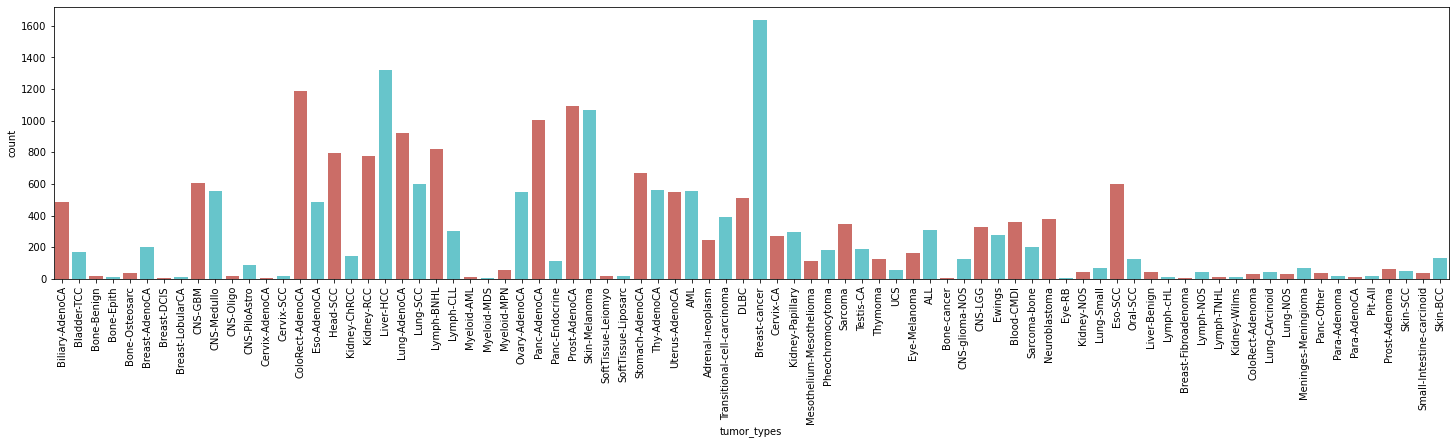

In [27]:
""" fig, ax = plt.subplots(3,1)
fig.set_size_inches(10,12)

sns.countplot(x=mutations_TCGA["tumor_types"], 
              palette=sns.hls_palette(2),
              ax=ax[0])
ax[0].tick_params(axis="x", rotation=90)

sns.countplot(x=mutations_PCWGA["tumor_types"], 
              palette=sns.hls_palette(2),
              ax=ax[1])
ax[1].tick_params(axis="x", rotation=90)

sns.countplot(x=mutations_all["tumor_types"], 
              palette=sns.hls_palette(2),
              ax=ax[2])
ax[2].tick_params(axis="x", rotation=90)

fig.tight_layout() """

plt.figure(figsize=(25, 5))
sns.countplot(x=profile_mut_all["tumor_types"], palette=sns.hls_palette(2))
plt.xticks(rotation=90);


### Testing with a single RandomForest binary classifier

Dimension of the training data (16680, 96) and test data (7149, 96)
Accuracy: 0.9795775632955658


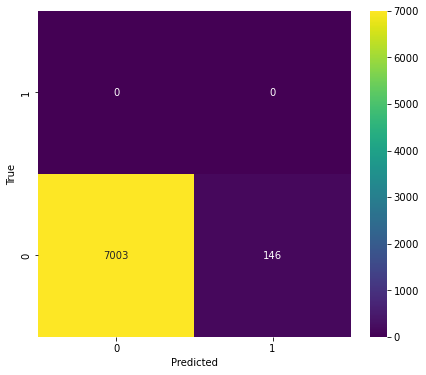

In [48]:
# For binary classification, construct y vector for a sigle selected tumor type

target_type = "Biliary-AdenoCA"

y_prf_bin = [1 if tumor_type == target_type else 0 for tumor_type in profile_mut_all["tumor_types"]]

# Split the data for fitting and prediction, use simple splitting here
X_prf_train, X_prf_test, y_prf_train, y_prf_test = train_test_split(X_prf, y_prf_bin, test_size = 0.3, random_state=1)


print(f"Dimension of the training data {X_prf_train.shape} and test data {X_prf_test.shape}")

# Make a model
model = RandomForestClassifier(n_estimators=100, random_state=0)

# Fit the model 
model.fit(X_prf_train, y_prf_train)

# Predict with unused (test) data 
y_prf_pred = model.predict(X_prf_test)

print(f"Accuracy:", accuracy_score(y_prf_test, y_prf_pred))

# Plot some results
plot_confusion_mat(y_prf_pred, y_prf_test)

### Multiple models experiment, but still binary classification

Note: this takes quite a while to compute

In [49]:
for tgt_tumor_type in unique_tumor_types:
    y_prf = [1 if tumor_type == tgt_tumor_type else 0 for tumor_type in profile_mut_all["tumor_types"]]
    X_prf_train, X_prf_test, y_prf_train, y_prf_test = train_test_split(X_prf, y_prf, test_size = 0.3, random_state=1)
    model = RandomForestClassifier(n_estimators=100, random_state=0)
    model.fit(X_prf_train, y_prf_train)
    y_prf_pred = model.predict(X_prf_test)
    print(f"Accuracy score for {tgt_tumor_type}: {accuracy_score(y_prf_test, y_prf_pred)}")


Accuracy score for ALL: 0.9875507063925024
Accuracy score for AML: 0.9790180444817457
Accuracy score for Adrenal-neoplasm: 0.9889495034270528
Accuracy score for Biliary-AdenoCA: 0.9795775632955658
Accuracy score for Bladder-TCC: 0.9934256539376136
Accuracy score for Blood-CMDI: 0.9896489019443279
Accuracy score for Bone-Benign: 0.9994404811861799
Accuracy score for Bone-Epith: 0.9995803608896349
Accuracy score for Bone-Osteosarc: 0.9980416841516296
Accuracy score for Bone-cancer: 0.99972024059309
Accuracy score for Breast-AdenoCA: 0.9913274583857882
Accuracy score for Breast-DCIS: 0.9998601202965449
Accuracy score for Breast-Fibroadenoma: 0.9994404811861799
Accuracy score for Breast-LobularCA: 0.9994404811861799
Accuracy score for Breast-cancer: 0.9328577423415862
Accuracy score for CNS-GBM: 0.9739823751573646
Accuracy score for CNS-LGG: 0.9862917890614072
Accuracy score for CNS-Medullo: 0.9749615330815499
Accuracy score for CNS-Oligo: 0.9991607217792698
Accuracy score for CNS-PiloAstr